In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

2024-04-07 16:22:36.957234: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 16:22:36.957343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 16:22:37.059562: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
t = 0
input_texts = []
target_texts = []
target_input_texts = []

for line in open(('/kaggle/input/ben-eng/ben.txt'), encoding = 'utf8'):
    t += 1

    if t > 20000:
        break
    if '\t' not in line:
        continue

    text_input, translate, *rest = line.rstrip().split('\t')
    text_target = translate + ' <eos>'
    text_target_input = '<sos> ' + translate

    input_texts.append(text_input)
    target_texts.append(text_target)
    target_input_texts.append(text_target_input)

len((input_texts))

6513

In [3]:
for line in open(('/kaggle/input/eng-beng-data/eng-ben_new.tsv'), encoding = 'utf8'):
    t += 1
    
    if t > 20000:
        break
        
    if '\t' not in line:
        continue
    
    rest_1, text_input, rest_2, translate = line.rstrip().split('\t')
    text_target = translate + ' <eos>'
    text_target_input = '<sos> ' + translate

    input_texts.append(text_input)
    target_texts.append(text_target)
    target_input_texts.append(text_target_input)

len((input_texts))

15277

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer_input = Tokenizer(num_words = 20000)
tokenizer_input.fit_on_texts(input_texts)
sequence_input = tokenizer_input.texts_to_sequences(input_texts)

word2idx_inputs = tokenizer_input.word_index
num_word_inputs = len(word2idx_inputs) + 1
max_input_len = max(len(s) for s in sequence_input)

tokenizer_output = Tokenizer(num_words = 20000, filters = '')
tokenizer_output.fit_on_texts(target_texts + target_input_texts)
sequence_target = tokenizer_output.texts_to_sequences(target_texts)
sequence_target_input = tokenizer_output.texts_to_sequences(target_input_texts)

word2idx_outputs = tokenizer_output.word_index
num_word_outputs = len(word2idx_outputs) + 1
max_target_len = max(len(s) for s in sequence_target)
max_target_input_len = max(len(s) for s in sequence_target_input)

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
encoder_input = pad_sequences(sequence_input, maxlen = max_input_len)
print("encoder_input[0] : ", encoder_input[0])
print("encoder_input.shape : ", encoder_input.shape)

decoder_input = pad_sequences(sequence_target_input, maxlen = max_target_len, padding = 'post')
print("decoder_input[0] : ", decoder_input[0])
print("decoder_input.shape : ", decoder_input.shape)

decoder_target = pad_sequences(sequence_target, maxlen = max_target_len, padding = 'post')
print("decoder_target[0] : ", decoder_target[0])
print("decoder_target.shape : ", decoder_target.shape)

encoder_input[0] :  [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 30]
encoder_input.shape :  (15277, 34)
decoder_input[0] :  [  2 226   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
decoder_input.shape :  (15277, 27)
decoder_target[0] :  [226   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
decoder_target.shape :  (15277, 27)


In [6]:
word2vec = {}

with open(os.path.join('/kaggle/input/globe-6b/glove.6B.100d.txt'), encoding = 'utf8') as f:
    for line in f:
        value = line.split()
        word = value[0]
        vec = np.asarray(value[1], dtype = 'float32')
        word2vec[word] = vec

In [7]:
num_words = min(20000, num_word_inputs)
embedding_matrix = np.zeros((num_words, 100))

for word, i in word2idx_inputs.items():
    if i < 20000:
        embedding_vec = word2vec.get(word)
        if embedding_vec is not None:
            embedding_matrix[i] = embedding_vec

In [8]:
decoder_target_one_hot = np.zeros((
    len(input_texts),
    max_target_len,
    num_word_outputs
), dtype = 'float32')

for i, d in enumerate(decoder_target):
    for t, word in enumerate(d):
        if word != 0:
            decoder_target_one_hot[i, t, word] = 1

decoder_target_one_hot.shape

(15277, 27, 7441)

In [9]:
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [10]:
embedding_layer = Embedding(num_words, 100)
embedding_layer.build(None, )
embedding_layer.set_weights([embedding_matrix])

In [11]:
encoder_input_layer = Input(shape = (max_input_len, ))
encoder_embedding_layer = embedding_layer(encoder_input_layer)
encoder = LSTM(256, return_state = True)
encoder_outputs, h, c = encoder(encoder_embedding_layer)
encoder_states = [h, c]

decoder_input_layer = Input(shape = (max_target_len, ))
decoder_embedder = Embedding(num_word_outputs, 100)
decoder_embedding_layer = decoder_embedder(decoder_input_layer)
decoder_lstm = LSTM(256, return_sequences = True, return_state = True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding_layer, initial_state = encoder_states)
decoder_dense = Dense(num_word_outputs, activation = 'softmax')
decoder_output_layer = decoder_dense(decoder_outputs)

model = Model([encoder_input_layer, decoder_input_layer], decoder_output_layer)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 27)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 100)   │    402,900 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 27, 100)   │    744,100 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    365,568 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 27, 256), │    365,568 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 27, 7441)  │  1,912,337 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,790,473 (14.46 MB)

 Trainable params: 3,790,473 (14.46 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
def custom_loss(y_true, y_pred):
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)


def acc(y_true, y_pred):
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')

  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total

model.compile(loss = custom_loss, optimizer = 'adam', metrics = [acc])


In [13]:
r = model.fit([encoder_input, decoder_input], decoder_target_one_hot, epochs = 40, batch_size = 64, validation_split = 0.2)

Epoch 1/40
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 102ms/step - acc: 0.1891 - loss: 6.7610 - val_acc: 0.1862 - val_loss: 6.5282
Epoch 2/40
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - acc: 0.2292 - loss: 5.3503 - val_acc: 0.1934 - val_loss: 6.3736
Epoch 3/40
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - acc: 0.2427 - loss: 4.9569 - val_acc: 0.1978 - val_loss: 6.2369
Epoch 4/40
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - acc: 0.2678 - loss: 4.6446 - val_acc: 0.2036 - val_loss: 6.0485
Epoch 5/40
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - acc: 0.2984 - loss: 4.3031 - val_acc: 0.2229 - val_loss: 5.8749
Epoch 6/40
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - acc: 0.3376 - loss: 3.9232 - val_acc: 0.2386 - val_loss: 5.7304
Epoch 7/40
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - acc: 0.3764 - loss: 3.5783 - val_acc: 0.2505 - val_loss: 5.6222
Epoch 8/40
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - acc: 0.4077 - loss: 3.2738 - val_acc: 0.2644 - val_loss: 5.5346
Epoch 9/40
191/191 ━━━━━━━━━━━━━━━━━━━━

In [14]:
model.save('s2snew2.h5')

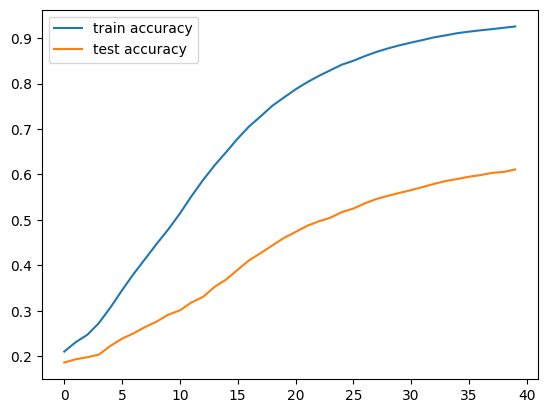

In [15]:
plt.plot(r.history['acc'], label = 'train accuracy')
plt.plot(r.history['val_acc'], label = 'test accuracy')
plt.legend()
plt.show()

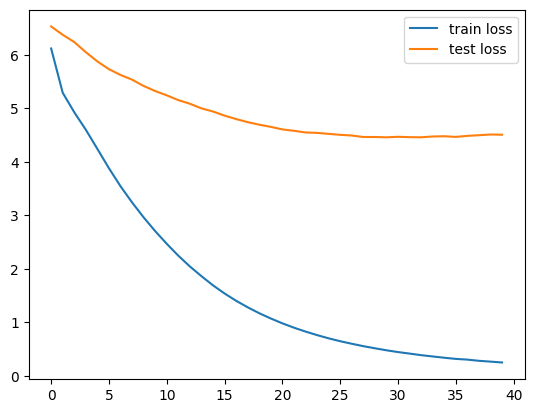

In [16]:
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend()
plt.show()

In [17]:
encoder_model = Model(encoder_input_layer, encoder_states)

decoder_input_state_h = Input(shape = (256, ))
decoder_input_state_c = Input(shape = (256, ))
decoder_input_state = [decoder_input_state_h, decoder_input_state_c]

decoder_input_single = Input(shape = (1, ))
decoder_input_single_embedding_layer = decoder_embedder(decoder_input_single)

decoder_output_new, h, c = decoder_lstm(decoder_input_single_embedding_layer, initial_state = decoder_input_state)
decoder_output_states = [h, c]
decoder_output_layer_new = decoder_dense(decoder_output_new)

decoder_model = Model([decoder_input_single] + decoder_input_state, [decoder_output_layer_new] + decoder_output_states)

In [18]:
encoder_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 34)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 34, 100)        │       402,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ [(None, 256), (None,   │       365,568 │
│                                 │ 256), (None, 256)]     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 768,468 (2.93 MB)

 Trainable params: 768,468 (2.93 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
decoder_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 100)    │    744,100 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 1, 256),  │    365,568 │ embedding_1[1][0… │
│                     │ (None, 256),      │            │ input_layer_2[0]… │
│                     │ (None, 256)]      │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 7441)   │  1,912,337 │ lstm_1[1][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,022,005 (11.53 MB)

 Trainable params: 3,022,005 (11.53 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
idx2word_end = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [32]:
def decoder_sequence(input_str):
    input_seq = tokenizer_input.texts_to_sequences([input_str])
    inputseq_padded = pad_sequences(input_seq, maxlen = max_input_len)
    state_value = encoder_model.predict(inputseq_padded)
    target_value = np.zeros((1, 1))
    target_value[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']

    output_sequence = []

    for _ in range(max_target_len):
        output_tokens, h, c = decoder_model.predict([target_value] + state_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if idx == eos:
            break
        
        word = ''
        if idx > 0:
            word = idx2word_trans[idx]
            output_sequence.append(word)

        target_value[0, 0] = idx
        state_value = [h, c]
    return ' '.join(output_sequence)

input_real_str = "I play football."
translation_str = decoder_sequence(input_real_str)
print("Input : ", input_real_str)
print("Translate : ", translation_str)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Input :  I play football.
Translate :  আমি ফুটবল খেলি।
